In [1]:
import re
import os
import sys
from lca_algebraic import initProject
import pandas as pd
import numpy as np
import xarray as xr
import lca_algebraic as agb
from lca_algebraic import *
from lca_algebraic.stats import * 
import bw2data, bw2io
import bw2calc
from premise import *
import premise as prm
from itertools import zip_longest
from premise.geomap import Geomap
from premise_gwp import add_premise_gwp

In [2]:
sys.path.append('/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/') 
from utils import *
from utils.setup import *
from utils.setup_whdLCIA import *
from utils.getAct import *
from utils.utils import *
from utils.dlcia_functions import *

modify the setup.py file for reading Parameter excel sheet. here we use 'data/p_file/p_tech_perSSP_Y.xlsx' as the technology parameter file.  
Define your chosen methods in the setup.py file. Current methods are:  [('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')]
Mapping premise_remind_DB to SSPx:  {'SSP1-PkBudg500': 'ssp119', 'SSP1-PkBudg1150': 'ssp126', 'SSP2-Base': 'ssp245', 'SSP5-Base': 'ssp585'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
modify the setup.py file for reading Parameter excel sheet. currently, we use 'data/p_scn_test.xlsx' as the technology parameter file.  
Define your chosen methods in the setup.py file. Current example methods are :   ('IPCC 2021 - test-SSP119_MY2020 - year100', 'climate change', 'dIRF100')
Mapping premise_remind_DB to SSPx defined here:  {'SSP1-PkBudg500': 'ssp119', 'SSP1-PkBudg11

In [3]:
bw2data.projects.set_current('iveo_v1')
mybio = bw2data.Database("biosphere3")
initProject("iveo_v1")

Biosphere database already present!!! No setup is needed


In [4]:
print( ssp_scn  , ssp_yr) 
bw2_method_metric = 'dIRF'
ds_rename = 'dpIRF'

root_path = '/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/'
tech_p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/p_tech_perSSP_Y.xlsx'))
consmp_p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/tech_conversion_veh_p/p_scn_v_need_tech.xlsx'))

['_remind_SSP1-PkBudg500', '_remind_SSP1-PkBudg1150', '_remind_SSP2-Base', '_remind_SSP5-Base'] [2030, 2040, 2050]


### init 

In [5]:
pdb = bw.Database("iveo_Parameterized_v1")
print(len(pdb))

370


In [6]:
#resetParams()
agb.loadParams()
agb.list_parameters()

[ParamRegistry] Param NMC622_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param NCA_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LFP_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LTO_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_cell_assmb_NG_MJperkg was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_cell_assmb_elec_kWhperkg was already defined in '<project>' : overriding.
[ParamRegistry] Param g_truck_vehicle_prod_lightweighting was already defined in '<project>' : overriding.
[ParamRegistry] Param battery_total_capacity_for_gtruck was already defined in '<project>' : overriding.
[ParamRegistry] Param biodiesel_UCO_perc was already defined in '<project>' : overriding.
[ParamRegistry] Pa

group,name,label,default,min,max,std,distrib,unit,db
battery,LFP_battery_cell_density,LFP battery cell density,0.21054,0.2,0.308252,,triangle,kWh/kg,[project]
battery,LSB_battery_cell_density,LSB battery cell density,0.5,0.2954,0.73,,triangle,kWh/kg,[project]
battery,LSB_cell_assmb_NG_MJperkg,LSB cell assmb NG MJperkg,5.47,2.88,5.47,,linear,MJ,[project]
battery,LSB_cell_assmb_elec_kWhperkg,LSB cell assmb elec kWhperkg,1.38,0.65,1.38,,linear,kWh,[project]
battery,LTO_battery_cell_density,LTO battery cell density,0.21054,0.2,0.308252,,triangle,kWh/kg,[project]
battery,NCA_battery_cell_density,NCA battery cell density,0.303589,0.25,0.444485,,triangle,kWh/kg,[project]
battery,NMC622_battery_cell_density,NMC622 battery cell density,0.29161,0.25,0.426946,,triangle,kWh/kg,[project]
diesel,biodiesel_UCO_perc,biodiesel UCO perc,0.011,0.00925,0.01225,,linear,fraction,[project]
diesel,biodiesel_algea_perc,biodiesel algea perc,0.011,0.00925,0.01225,,linear,fraction,[project]
diesel,biodiesel_rapeseedoil_perc,biodiesel rapeseedoil perc,0.011,0.00925,0.01225,,linear,fraction,[project]


In [7]:
gtruck_diesel_allsspyear = [] 
for prm_name in ssp_scn:
    for year_t in ssp_yr: 
        bg_db_ssp_yr = bg_ei_ + prm_name + "_" + str(year_t)            # backgroun database (BD) to use for SSP[x], Year[t]
        copied_prm_UPR_suffix = "_from_" + prm_name + "_" + str(year_t) # copy UPR from BD to PDB for further use/modification if needed
        newUPR_suffix =  "_wh_" + prm_name + "_" + str(year_t)          # naming on any new UPRs created in PDB
        act = agb.findActivity( db_name = PDB_NAME, name="Diesel_mix_with_conv_and_biodiesel_perkg_" + newUPR_suffix )
        gtruck_diesel_allsspyear.append(act)

len(gtruck_diesel_allsspyear)

12

### read in TRL table to see which switch_P to apply - not needed for diesel

### C.2 read all P file - for diesel, need 1. tech_p_file , 2. consmp_p_file 
1. the tech_p_file to read YearlyP for diesel market share, needed in lca calculation 
2. the consumption amount of diesel consumption is a parameter file located  
        "self.fpath = fpath     #os.path.join('data/P_files/tech_conversion_veh_p/', 'p_scn_v_need_tech.xlsx')" 


#### C.2.0 testing reading tech_p file

In [8]:
root_path = '/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/'
tech_p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/p_tech_perSSP_Y.xlsx'))

for diesel_final in gtruck_diesel_allsspyear:
    # need a matched YearlyParams for each SSPx:
    str1 = diesel_final.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int( str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)
    
    yearlyParams = loadYearlyParams(PARAMS_FILE = tech_p_file, s_name = "F2_fuel_d_whbio", years = [year_to_get_inP], SSP = ssp_to_get_inP) 
    print(f"for SSP {ssp_to_get_inP}, year {year_to_get_inP}, P:  {yearlyParams}" )

for SSP ssp119, year 2030, P:  {'biodiesel_UCO_perc': [0.01100000000000001], 'biodiesel_rapeseedoil_perc': [0.01100000000000001], 'biodiesel_soybeanoil_perc': [0.01100000000000001], 'biodiesel_algea_perc': [0.01100000000000001], 'conv_diesel_perc': [0.956]}
for SSP ssp119, year 2040, P:  {'biodiesel_UCO_perc': [0.015500000000000014], 'biodiesel_rapeseedoil_perc': [0.015500000000000014], 'biodiesel_soybeanoil_perc': [0.015500000000000014], 'biodiesel_algea_perc': [0.015500000000000014], 'conv_diesel_perc': [0.938]}
for SSP ssp119, year 2050, P:  {'biodiesel_UCO_perc': [0.036574999999999996], 'biodiesel_rapeseedoil_perc': [0.036574999999999996], 'biodiesel_soybeanoil_perc': [0.036574999999999996], 'biodiesel_algea_perc': [0.036574999999999996], 'conv_diesel_perc': [0.8537]}
for SSP ssp126, year 2030, P:  {'biodiesel_UCO_perc': [0.01100000000000001], 'biodiesel_rapeseedoil_perc': [0.01100000000000001], 'biodiesel_soybeanoil_perc': [0.01100000000000001], 'biodiesel_algea_perc': [0.01100000

#### C.2.1 testing reading consmp_P file  (for fuel, it's the annual consumption value)

##### function to get yearly_consumption_P :: utils / dlcia_funtions.py / get_f2_fuel_diesel_kg()  

In [9]:
consmp_p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/tech_conversion_veh_p/p_scn_v_need_tech.xlsx'))
v_lifetime = 20
v_yearlyFU = [12000] * v_lifetime  #assuming each year running same mileage

for act_tocalc in gtruck_diesel_allsspyear:
    #print(act_tocalc)
    # need a matched YearlyParams for each SSPx:
    str1 = act_tocalc.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int( str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)
 
    
    v_pneed = loadYearlyParamswhsize(PARAMS_FILE = consmp_p_file, s_name = 'g_truck', hypothesis = 'point value', 
                               years = [year_to_get_inP], SSP = ssp_to_get_inP, size = 'HDV_class7')
    
    """ final run year should be v_lifetime, if assuming it starts running from YEAR[0], then no need to adding (v_lifetime+1) in range() """ 
    for Y in range(year_to_get_inP+1, year_to_get_inP + v_lifetime + 1,  1):  
        """ no need to read in tech_avail ds for diesel   """ 
        get_f2_fuel_diesel_kg(Y, v_lifetime = 20, v_yearlyFU = v_yearlyFU , SP = ssp_to_get_inP,year_inP = year_to_get_inP,  v_pneed = v_pneed )


  ⛽️⛽️ for v_year2030, running_year 2031, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for v_year2030, running_year 2032, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for v_year2030, running_year 2033, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for v_year2030, running_year 2034, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for v_year2030, running_year 2035, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for v_year2030, running_year 2036, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for v_year2030, running_year 2037, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for v_year2030, running_year 2038, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for v_year2030, running_year 2039, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for v_year2030, running_year 2040, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for v_year2030, running_year 2041, SSP ssp119, the annual diesel_consump is 4788.0
  ⛽️⛽️ for

### C.2.B - calculate all running_year impacts from elec 

#### adding a running_Y loop 

In [10]:
v_lifetime = 20
v_yearlyFU = [12000] * v_lifetime 

#final output to be appended
act_lcia_dict = {}

GWP_list, SSP_list, Year_list, tech_list, run_Y_list  = [], [],[], [], []

""" first loop is for each v_year:: [year_to_get_inP] and  SSP:: [ssp_to_get_inP]""" 
for act_tocalc in gtruck_diesel_allsspyear:
    # need a matched YearlyParams for each SSPx:
    str1 = act_tocalc.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int( str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)

    """ for each LCI scenario, using a respective SSP[x] as the dLCIA method """ 
    chosen_methods_perssp = get_my_dpLCIA(ssp = ssp_to_get_inP, my = year_to_get_inP, metric = bw2_method_metric )

    """ for ICEV-d, add a dummy tech under SSPx, Yeart, since it doens't have switch_tech """
    """ still keep a dummy_tech, so that final results ds shape is same as BEV """ 
    for tech in ['dummy_tech'] : 
        run_Y_GWP_list,run_Y_SSP_list, run_Y_Year_list, run_Y_tech_list, run_Y = [],[],[],[],[] 

        """ final run year should be v_lifetime, from Year[1] to Y[v_lifetime] """ 
        for Y in range(year_to_get_inP + 1, year_to_get_inP + v_lifetime + 1,  1): 
                        
            """ we read in P_files for each year, we have values for each five year gap, more detailed than the v_year per 10 years, """ 
            yr_toget = min([2030, 2035, 2040, 2045, 2050], key=lambda x: abs(x - Y))
            """ read tech_P file """
            yearlyParams = loadYearlyParams(PARAMS_FILE = tech_p_file, s_name = "F2_fuel_d_whbio", years = [yr_toget], SSP = ssp_to_get_inP) 
            print(f"for v_year {year_to_get_inP} and running {Y}, get cloest year from P_files {yr_toget} " )
            """ read consmp_P file, to be used in get_f2_fuel_diesel_kg() to get the act_amount """
            v_pneed = loadYearlyParamswhsize(PARAMS_FILE = consmp_p_file, s_name = 'g_truck', hypothesis = 'point value', 
                                           years = [yr_toget], SSP = ssp_to_get_inP, size = 'HDV_class7') 

            " get diesel consumption amount each run_y under SSP[x], MY[t]"
            act_amount = get_f2_fuel_diesel_kg(Y, v_lifetime = v_lifetime, v_yearlyFU = v_yearlyFU, SP = ssp_to_get_inP, year_inP = year_to_get_inP, v_pneed = v_pneed )
            df = agb.multiLCAAlgebric(models=[
                    (act_tocalc, act_amount)],  #act_test
                    methods = chosen_methods_perssp,   
                    #define switch parameter here if you have one, otherwise, using the default value, e.g., assuming assembly @CA_QC 
                    #gtruck_BEV_elec_tech = e_tech ,
                    **yearlyParams
                )
            print(f"end of running LCA calc for SSP {ssp_to_get_inP} and year {year_to_get_inP}   ")
            #display(df)
        
            # to have all 100 years run for dynamic LCIA   
            lcia_allyears = [] 
            for t in range(len(df.columns)): 
                lcia_t = df.iloc[:,t].values[0]
                lcia_allyears.append(lcia_t)
            
            run_Y_GWP_list.append(lcia_allyears)
            run_Y_SSP_list.append(ssp_to_get_inP) 
            run_Y_Year_list.append(year_to_get_inP)
            run_Y_tech_list.append(tech)
            run_Y.append(Y)
            #print(len(run_Y_GWP_list),len(run_Y_SSP_list),len(run_Y_Year_list),len(run_Y_tech_list),len(run_Y))
        
        GWP_list.append(run_Y_GWP_list)
        SSP_list.append(run_Y_SSP_list) 
        Year_list.append(run_Y_Year_list)
        tech_list.append(run_Y_tech_list)        
        run_Y_list.append(run_Y)


dpLCIA methods to be used for SSP 119, MY2030 is  e.g.,:('IPCC 2021 - test-SSP119_MY2030 - year36', 'climate change', 'dIRF36'),  with total len: 100  
for v_year 2030 and running 2031, get cloest year from P_files 2030 
  ⛽️⛽️ for v_year2030, running_year 2031, SSP ssp119, the annual diesel_consump is 4788.0
end of running LCA calc for SSP ssp119 and year 2030   
for v_year 2030 and running 2032, get cloest year from P_files 2030 
  ⛽️⛽️ for v_year2030, running_year 2032, SSP ssp119, the annual diesel_consump is 4788.0
end of running LCA calc for SSP ssp119 and year 2030   
for v_year 2030 and running 2033, get cloest year from P_files 2035 
  ⛽️⛽️ for v_year2030, running_year 2033, SSP ssp119, the annual diesel_consump is 4788.0
end of running LCA calc for SSP ssp119 and year 2030   
for v_year 2030 and running 2034, get cloest year from P_files 2035 
  ⛽️⛽️ for v_year2030, running_year 2034, SSP ssp119, the annual diesel_consump is 4788.0
end of running LCA calc for SSP ssp119 and y

#### prepare DF / DS 

In [11]:
d1 = get_dlcia_rawtable_a(SSP_list,run_Y_list,tech_list, Year_list, GWP_list)
lcia_ds = get_dlcia_ds_b(d1) 
ds = get_dlcia_final_ds_empty_c(lcia_ds, v_module_touse = ['F2_fuel_diesel']) 

 enter one of the following for v_module to arrange dpLCIA results:  ['V1A_V1B_init'] for init_veh both ICEV&BEV,           ['V1B']/ for BEV bat replacement, ['V2_oper'] for ICEV on-road emissions,  ['F2_fuel_diesel'] or ['F2_fuel_elec'] for fuel 
empty final ds prepared with fake data


In [12]:
d1

1             2             3    \
SSP    v_year tech_list  run_year                                             
ssp119 2030   dummy_tech 2031      8.244655e-12  7.569564e-12  6.949682e-12   
                         2032      8.244655e-12  7.569564e-12  6.949682e-12   
                         2033      8.040530e-12  7.379147e-12  6.770892e-12   
                         2034      8.040530e-12  7.379147e-12  6.770892e-12   
                         2035      8.040530e-12  7.379147e-12  6.770892e-12   
...                                         ...           ...           ...   
ssp585 2050   dummy_tech 2066      9.824134e-12  9.034022e-12  8.327481e-12   
                         2067      9.824134e-12  9.034022e-12  8.327481e-12   
                         2068      9.824134e-12  9.034022e-12  8.327481e-12   
                         2069      9.824134e-12  9.034022e-12  8.327481e-12   
                         2070      9.824134e-12  9.034022e-12  8.327481e-12   

                                            4             5             6    \
SSP    v_year tech_list  run_year                                             
ssp119 2030   dummy_tech 2031      6.378824e-12  5.852437e-12  5.364667e-12   
                         2032      6.378824e-12  5.852437e-12  5.364667e-12   
                         2033      6.209972e-12  5.692142e-12  5.211804e-12   
                         2034      6.209972e-12  5.692142e-12  5.211804e-12   
                         2035      6.209972e-12  5.692142e-12  5.211804e-12   
...                                         ...           ...           ...   
ssp585 2050   dummy_tech 2066      7.688588e-12  7.118233e-12  6.598345e-12   
                         2067      7.688588e-12  7.118233e-12  6.598345e-12   
                         2068      7.688588e-12  7.118233e-12  6.598345e-12   
                         2069      7.688588e-12  7.118233e-12  6.598345e-12   
                         2070      7.688588e-12  7.118233e-12  6.598345e-12   

                                            7             8             9    \
SSP    v_year tech_list  run_year                                             
ssp119 2030   dummy_tech 2031      4.915436e-12  4.496782e-12  4.113260e-12   
                         2032      4.915436e-12  4.496782e-12  4.113260e-12   
                         2033      4.769062e-12  4.356140e-12  3.977677e-12   
                         2034      4.769062e-12  4.356140e-12  3.977677e-12   
                         2035      4.769062e-12  4.356140e-12  3.977677e-12   
...                                         ...           ...           ...   
ssp585 2050   dummy_tech 2066      6.125124e-12  5.696393e-12  5.309969e-12   
                         2067      6.125124e-12  5.696393e-12  5.309969e-12   
                         2068      6.125124e-12  5.696393e-12  5.309969e-12   
                         2069      6.125124e-12  5.696393e-12  5.309969e-12   
                         2070      6.125124e-12  5.696393e-12  5.309969e-12   

                                            10   ...           91   \
SSP    v_year tech_list  run_year                ...                 
ssp119 2030   dummy_tech 2031      3.760829e-12  ... -3.007856e-13   
                         2032      3.760829e-12  ... -3.007856e-13   
                         2033      3.629747e-12  ... -3.684138e-13   
                         2034      3.629747e-12  ... -3.684138e-13   
                         2035      3.629747e-12  ... -3.684138e-13   
...                                         ...  ...           ...   
ssp585 2050   dummy_tech 2066      4.955200e-12  ...  9.065322e-13   
                         2067      4.955200e-12  ...  9.065322e-13   
                         2068      4.955200e-12  ...  9.065322e-13   
                         2069      4.955200e-12  ...  9.065322e-13   
                         2070      4.955200e-12  ...  9.065322e-13   

                                            92   

In [13]:
lcia_ds

<xarray.Dataset>
Dimensions:    (SSP: 4, v_year: 3, tech_list: 1, run_year: 40, lcia_year: 100)
Coordinates:
  * SSP        (SSP) object 'ssp119' 'ssp126' 'ssp245' 'ssp585'
  * v_year     (v_year) int64 2030 2040 2050
  * tech_list  (tech_list) object 'dummy_tech'
  * run_year   (run_year) int64 2031 2032 2033 2034 2035 ... 2067 2068 2069 2070
  * lcia_year  (lcia_year) int64 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100
Data variables:
    value      (SSP, v_year, tech_list, run_year, lcia_year) float64 8.245e-1...

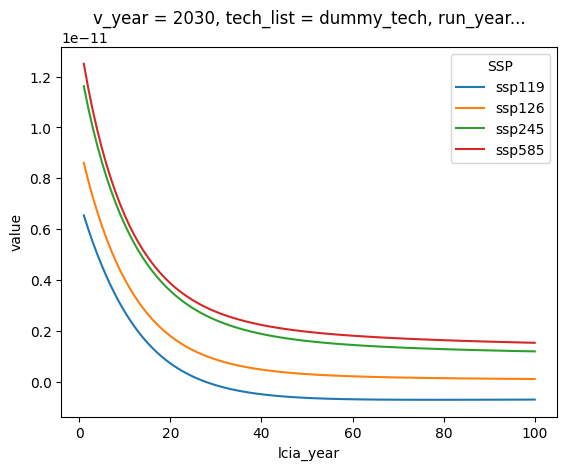

In [14]:
lcia_ds.sel(v_year = 2030, run_year = 2045, tech_list = "dummy_tech")['value'].plot(x='lcia_year', hue='SSP');

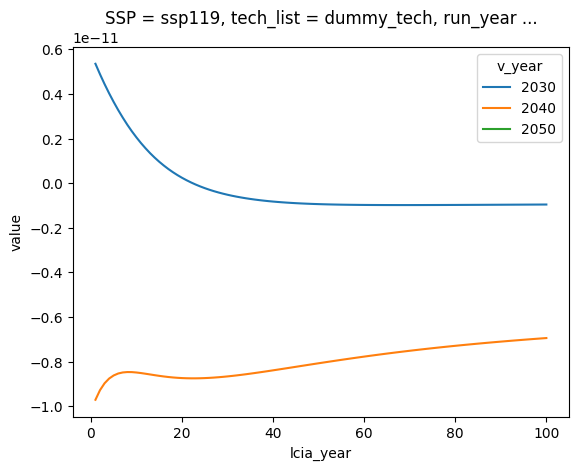

In [15]:
lcia_ds.sel(tech_list = "dummy_tech",  run_year = 2048, SSP = "ssp119")['value'].plot(x='lcia_year', hue='v_year');

### C.3. to sum  Y1 - 100+TH impacts for each year, 
caz for each run_year under v_year[2030], e.g., run_y[2031-2050] impacts, it'll be there for the next 20+100,  so for e.g., lcia_year[5], its run_y[2031 + ... + 2036] 

#### C.3.1. create a new empty ds with the correct dimension: 
- SSP -> 'ssp119' 'ssp126' 'ssp245' 'ssp585'
- v_year ->  2030 2040 2050
- v_module -> 'F2_fuel_elec' / 'F2_fuel_diesel'
- tech_list ->  'grid' 'onsite100PV'
- run_year -> no need for run_year, as it will be summed for final LCIA_year with a TH (100 + run_year)
- lcia_year -> initial LCIA_year (100) + run_year
- ensemble -> ds has 1001 as max. possible shape, though now we only have fixed CF values, so using ensemble = 0 when assigning

#### C.3.2. assign the data var dlcia to the ds for each / SSP / Year  /  lcia_year

In [16]:
all_sspYrunY_list = [] 
mod_toget = "F2_fuel_diesel" 

""" to improve: write a class:  lcia_ds = self.lcia_ds run from above C.2  """
for sp in lcia_ds['SSP'].values:
    for v_y  in lcia_ds['v_year'].values:
        for tech in lcia_ds['tech_list'].values:
            
            """ for each running year, need to prepare d-lcia scores """ 
            run_y_list = []
            for r_y in lcia_ds['run_year'].values:
                sel_ds = lcia_ds.sel(SSP = sp, v_year = v_y, tech_list = tech, run_year = r_y) 
                sel_ds1 = sel_ds.where(sel_ds['value'].notnull() , drop = True)
                if len(sel_ds1['value'].values) != 0 : 
                    run_y_list.append(sel_ds1['value'].values)
                else:
                    pass
            
            """ 1. add N * [0] for each future run_year so that it can be summed later """
            final_run_y_list, run_y_list_padded = [] , []
            for i in range(len(run_y_list)):  
                # Create a numpy array with i zeros, depending on future year position 
                shape = (i, )
                zeros = np.zeros(shape) 
                run_y_list_padded = np.concatenate((zeros, run_y_list[i]))
                """ 2. append each year to the final list, to sum later """ 
                final_run_y_list.append(run_y_list_padded)
            
            """ 3. sum over all running years' lcia score for TH:Year[0] + Year[100+lci_year] """ 
            allrun_y_lcia = [sum(filter(None, x)) for x in zip_longest(*final_run_y_list, fillvalue=0)]
            
            to_addvar_ds_shape = ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module': mod_toget, 'tech_list':tech, 'ensemble':0}].shape 
            """ in case for certain tech, not have it available, so its (0,) dim"""
            #print(np.array(allrun_y_lcia).shape)
            if to_addvar_ds_shape == np.array(allrun_y_lcia).shape: 
                ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'ensemble':0}] = np.array(allrun_y_lcia)
            else:
                ds['dplcia'].loc[{'SSP': sp, 'v_year': v_y, 'v_module':mod_toget, 'tech_list':tech, 'ensemble':0}] = np.full(to_addvar_ds_shape, np.nan)

            all_sspYrunY_list.append(allrun_y_lcia)

In [17]:
ds = ds.rename_vars({'dplcia': ds_rename})

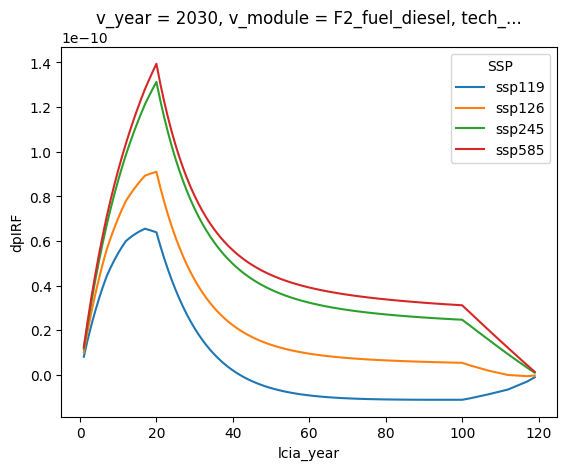

In [18]:
ds.sel(v_year = 2030, tech_list = 'dummy_tech', v_module = "F2_fuel_diesel", ensemble = 0 )[ds_rename].plot(x='lcia_year', hue = 'SSP' );

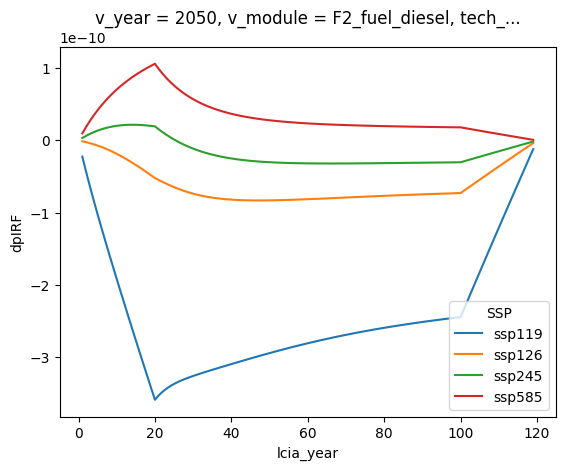

In [19]:
ds.sel(v_year = 2050, v_module = "F2_fuel_diesel", tech_list = 'dummy_tech', ensemble = 0 )[ds_rename].plot(x='lcia_year', hue='SSP');

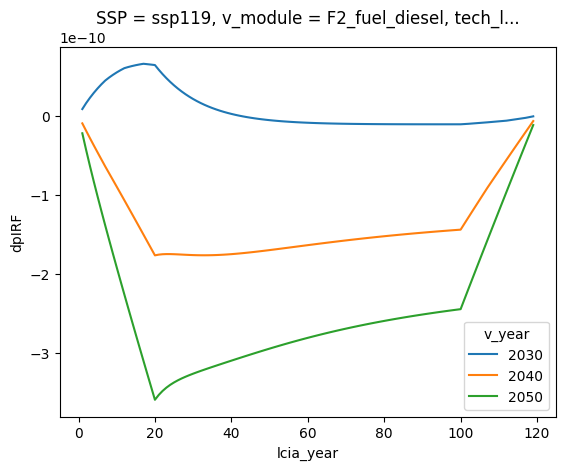

In [20]:
ds.sel(SSP = "ssp119", v_module = "F2_fuel_diesel", tech_list = 'dummy_tech', ensemble = 0 )[ds_rename].plot(x='lcia_year', hue='v_year');

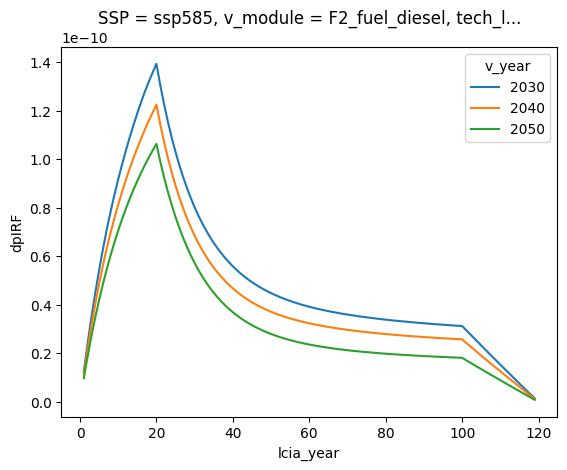

In [21]:
ds.sel(SSP = "ssp585", v_module = "F2_fuel_diesel", tech_list = 'dummy_tech', ensemble = 0 )[ds_rename].plot(x='lcia_year', hue='v_year');

In [22]:
ds

<xarray.Dataset>
Dimensions:    (SSP: 4, v_year: 3, v_module: 1, tech_list: 1, lcia_year: 119,
                ensemble: 1001)
Coordinates:
  * SSP        (SSP) object 'ssp119' 'ssp126' 'ssp245' 'ssp585'
  * v_year     (v_year) int64 2030 2040 2050
  * v_module   (v_module) <U14 'F2_fuel_diesel'
  * tech_list  (tech_list) object 'dummy_tech'
  * lcia_year  (lcia_year) int64 1 2 3 4 5 6 7 8 ... 113 114 115 116 117 118 119
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    dpIRF      (SSP, v_year, v_module, tech_list, lcia_year, ensemble) float64 ...

In [23]:
ds.to_netcdf('../dlcia_output/F2_ICEVdGT_dpIRF_perSSPMY.nc')